# Sentiment analysis
## Amazon reviews


Sharmila S


In [2]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [3]:
print(tf.__version__)

2.4.0


### Load the dataset - train and test

Dataset from
https://drive.google.com/drive/folders/0Bz8a_Dbh9Qhbfll6bVpmNUtUcFdjYmF2SEpmZUZUcVNiMUw1TWN6RDV3a0JHT3kxLVhVR2M

In [5]:
train_df = pd.read_csv("./amazon_review_full_csv/train.csv", names=["ratings", "title", "text"])
train_df.head()

,ratings,title,text
0,3,more like funchuck,Gave this to my dad for a gag gift after direc...
1,5,Inspiring,I hope a lot of people hear this cd. We need m...
2,5,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
3,4,Chrono Cross OST,The music of Yasunori Misuda is without questi...
4,5,Too good to be true,Probably the greatest soundtrack in history! U...


In [6]:
train_df.shape

(3000000, 3)

In [7]:
test_df = pd.read_csv("./amazon_review_full_csv/test.csv", names=["ratings", "title", "text"])
test_df.head()

,ratings,title,text
0,1,mens ultrasheer,"This model may be ok for sedentary types, but ..."
1,4,Surprisingly delightful,This is a fast read filled with unexpected hum...
2,2,"Works, but not as advertised",I bought one of these chargers..the instructio...
3,2,Oh dear,I was excited to find a book ostensibly about ...
4,2,Incorrect disc!,"I am a big JVC fan, but I do not like this mod..."


In [8]:
test_df.shape

(650000, 3)

## Selecting a part of whole data initially

In [144]:
train_df_part = train_df[:100000]
valid_df_part = train_df[100000:125000]
train_df_part.shape, valid_df_part.shape

((100000, 3), (25000, 3))

In [145]:
test_df_part = test_df[:50000]
test_df_part.shape

(50000, 3)

In [146]:
train_df_part.head()


,ratings,title,text
0,3,more like funchuck,Gave this to my dad for a gag gift after direc...
1,5,Inspiring,I hope a lot of people hear this cd. We need m...
2,5,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
3,4,Chrono Cross OST,The music of Yasunori Misuda is without questi...
4,5,Too good to be true,Probably the greatest soundtrack in history! U...


In [15]:
text = train_df_part.head(1)['text']
text[0]

'Gave this to my dad for a gag gift after directing "Nunsense," he got a reall kick out of it!'

The dataset has title, text and ratings

We will be workign on text and ratings alone

In [20]:
train_df_part = train_df_part[['text', 'ratings']]
train_df_part.head()

,text,ratings
1,I hope a lot of people hear this cd. We need m...,5
2,I'm reading a lot of reviews saying that this ...,5
3,The music of Yasunori Misuda is without questi...,4
4,Probably the greatest soundtrack in history! U...,5
5,"There's a reason this CD is so expensive, even...",5


In [17]:
valid_df_part = valid_df_part[['text', 'ratings']]
valid_df_part.head()

,text,ratings
100000,The lies of the Reagan administration just kee...,1
100001,"Ya know, I really hate it when I see an actor ...",1
100002,"I bought this item 30 days ago, and it is alre...",1
100003,Bought this Combo Microwave/toaster in order t...,3
100004,"I've had this model since 2002, almost ten yea...",4


In [18]:
test_df_part = test_df_part[['text', 'ratings']]
test_df_part.head()

,text,ratings
0,"This model may be ok for sedentary types, but ...",1
1,This is a fast read filled with unexpected hum...,4
2,I bought one of these chargers..the instructio...,2
3,I was excited to find a book ostensibly about ...,2
4,"I am a big JVC fan, but I do not like this mod...",2


## The dataset has ratings of 1 to 5

We are going to drop the rows that has ratings 3

In [21]:
# drop rows with ratings as 3
index_names = train_df_part[ train_df_part['ratings'] == 3 ].index

train_df_part.drop(index_names, inplace = True)

index_names = valid_df_part[ valid_df_part['ratings'] == 3 ].index

valid_df_part.drop(index_names, inplace = True)

In [22]:
index_names = test_df_part[ test_df_part['ratings'] == 3 ].index

test_df_part.drop(index_names, inplace = True)

View countd for ratings

In [23]:
train_df_part['ratings'].value_counts()

5    20161
2    20107
4    19986
1    19188
Name: ratings, dtype: int64

In [24]:
valid_df_part['ratings'].value_counts()

5    5267
4    5113
2    4811
1    4745
Name: ratings, dtype: int64

In [25]:
test_df_part['ratings'].value_counts()

5    10252
2    10101
4     9881
1     9625
Name: ratings, dtype: int64

Now let's modify the ratings column such that, 1 and 2 (least rating) represent negative
4 and 5 (highest rating) represent positive feedback

In [31]:
train_df_part['ratings'] = train_df_part['ratings'].map({
    1: 0,
    2: 0,
    4: 1,
    5: 1,
})
valid_df_part['ratings'] = valid_df_part['ratings'].map({
    1: 0,
    2: 0,
    4: 1,
    5: 1,
})

train_df_part['ratings'].value_counts()

1    40147
0    39295
Name: ratings, dtype: int64

In [32]:
valid_df_part['ratings'].value_counts()

1    10380
0     9556
Name: ratings, dtype: int64

In [27]:
test_df_part['ratings'] = test_df_part['ratings'].map({
    1: 0,
    2: 0,
    4: 1,
    5: 1,
})

In [33]:
test_df_part['ratings'].value_counts()

1    20133
0    19726
Name: ratings, dtype: int64

# vectorisation

Remove stop words (common words with not much use) eg the, and etc

In [34]:
import nltk

In [36]:
from nltk.corpus import stopwords
# nltk.download('stopwords')

stop = set(stopwords.words("english"))

def remove_stopwords(text):
    text = [word for word in text.split() if word not in stop]

    return " ".join(text)

In [37]:
train_df_part['text'] = train_df_part['text'].map(remove_stopwords)

valid_df_part['text'] = valid_df_part['text'].map(remove_stopwords)

test_df_part['text'] = test_df_part['text'].map(remove_stopwords)

In [40]:
train_df_part['text']

1        I hope lot people hear cd. We need strong posi...
2        I'm reading lot reviews saying best 'game soun...
3        The music Yasunori Misuda without question clo...
4        Probably greatest soundtrack history! Usually ...
5        There's reason CD expensive, even version that...
                               ...                        
99994    After reading fabulous reviews book received I...
99995    While book starts well, quickly goes downhill....
99996    The product never received, I contact amazon l...
99997    If want balanced look Contra war, try reading ...
99998    Having Nicaragua years question wire-service p...
Name: text, Length: 79442, dtype: object

# Vectorisation layer

In [43]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')  

In [44]:
max_features = 15000
sequence_length = 100

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [46]:
train_target_df_part = train_df_part.pop('ratings')
train_target_df_part.shape

(79442,)

In [48]:
train_text_df_part = train_df_part.pop('text')
train_text_df_part.shape

(79442,)

In [49]:
train_text_ds = tf.data.Dataset.from_tensor_slices(
    (train_text_df_part.values, 
     train_target_df_part.values)
)

In [50]:
train_text_ds = train_text_ds.shuffle(len(train_df_part)).batch(32)
train_text_ds

<BatchDataset shapes: ((None,), (None,)), types: (tf.string, tf.int64)>

In [53]:
valid_target_df_part = valid_df_part.pop('ratings')
valid_text_df_part   = valid_df_part.pop('text')

valid_text_ds = tf.data.Dataset.from_tensor_slices((valid_text_df_part.values, valid_target_df_part.values))

valid_text_ds = valid_text_ds.shuffle(len(valid_df_part)).batch(32)
valid_text_ds

<BatchDataset shapes: ((None,), (None,)), types: (tf.string, tf.int64)>

In [56]:
test_target_df_part = test_df_part.pop('ratings')
test_text_df_part   = test_df_part.pop('text')

test_text_ds = tf.data.Dataset.from_tensor_slices((test_text_df_part.values, test_target_df_part.values))

test_text_ds = test_text_ds.shuffle(len(test_df_part)).batch(32)
test_text_ds

<BatchDataset shapes: ((None,), (None,)), types: (tf.string, tf.int64)>

# adapt train data to vector layer

In [59]:
# get the text
train_text = train_text_ds.map(lambda x, y: x)
train_text

<MapDataset shapes: (None,), types: tf.string>

In [60]:
vectorize_layer.adapt(train_text)

In [61]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

### View first record from first batch

In [62]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(train_text_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", first_label)
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Sidney Blumenthal explores Clinton years profoundly well written book resolves many questions caring reader time.I chuckle I read reviewer "a Clinton voter" proceeds take Sidney President Clinton apart. Only school boy see childish ploy justify ill founded opinions writing review.Take life long Republican forced leave party due low lifes occupy it. This great book beginning accurate look Clinton years about.', shape=(), dtype=string)
Label tf.Tensor(1, shape=(), dtype=int64)
Vectorized review (<tf.Tensor: shape=(1, 100), dtype=int64, numpy=
array([[14774,     1,  4514,  7217,    70,  9535,    19,   118,     3,
            1,    31,   751,  4130,   334,  6034, 11683,     2,    12,
         1015,    36,  7217,     1,  7764,   133, 14774,  2845,  7217,
          815,   537,   333,   627,    39,  4163, 12269,  3684,   360,
        11996,  2918,   189,     1,    79,    93,  8036,  1130,   655,
         1347,   646,   530,  4980,     1,     5,     6,    13,     3,
        

In [102]:
print("1200 ---> ",vectorize_layer.get_vocabulary()[1200])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1200 --->  writes
 313 --->  amazing
Vocabulary size: 15000


## WordCloud for training data

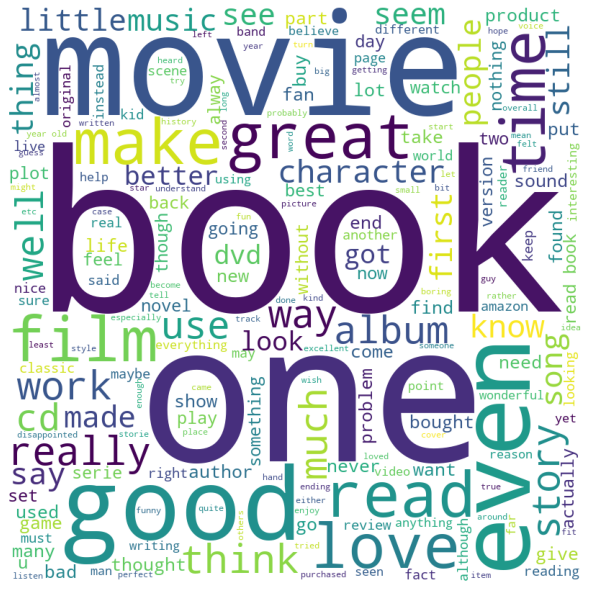

In [103]:
# importing all necessery modules
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
  
comment_words = ''
# stopwords = set(STOPWORDS)
  
# iterate through the csv file
for val in train_text_df_part:
      
    # typecaste each val to string
    val = str(val)
  
    # split the value
    tokens = val.split()
      
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
#                 stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
  
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()

In [64]:
train_text_ds, valid_text_ds, test_text_ds

(<BatchDataset shapes: ((None,), (None,)), types: (tf.string, tf.int64)>,
 <BatchDataset shapes: ((None,), (None,)), types: (tf.string, tf.int64)>,
 <BatchDataset shapes: ((None,), (None,)), types: (tf.string, tf.int64)>)

In [66]:
train_ds = train_text_ds.map(vectorize_text)
val_ds = valid_text_ds.map(vectorize_text)

test_ds = test_text_ds.map(vectorize_text)

In [67]:
train_ds, val_ds, test_ds

(<MapDataset shapes: ((None, 100), (None,)), types: (tf.int64, tf.int64)>,
 <MapDataset shapes: ((None, 100), (None,)), types: (tf.int64, tf.int64)>,
 <MapDataset shapes: ((None, 100), (None,)), types: (tf.int64, tf.int64)>)

In [68]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Build the model

In [69]:
embedding_dim = 16

In [136]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(16, activation=tf.nn.relu),
  layers.Dense(1, activation=tf.nn.sigmoid)
])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          240016    
_________________________________________________________________
dropout_6 (Dropout)          (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d_3 ( (None, 16)                0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 240,305
Trainable params: 240,305
Non-trainable params: 0
________________________________________________

In [137]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
    optimizer=tf.keras.optimizers.Adam(3e-4),
    metrics=tf.metrics.BinaryAccuracy(threshold=0.05)
)

In [138]:
epochs = 10

In [139]:
history = model.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=epochs
)

Epoch 1/10
2483/2483 [==============================] - 12s 4ms/step - loss: 0.7033 - binary_accuracy: 0.5052 - val_loss: 0.6668 - val_binary_accuracy: 0.5419
Epoch 2/10
2483/2483 [==============================] - 9s 4ms/step - loss: 0.6421 - binary_accuracy: 0.6022 - val_loss: 0.5902 - val_binary_accuracy: 0.7563
Epoch 3/10
2483/2483 [==============================] - 8s 3ms/step - loss: 0.5883 - binary_accuracy: 0.7766 - val_loss: 0.5774 - val_binary_accuracy: 0.8162
Epoch 4/10
2483/2483 [==============================] - 9s 3ms/step - loss: 0.5750 - binary_accuracy: 0.8260 - val_loss: 0.5727 - val_binary_accuracy: 0.8329
Epoch 5/10
2483/2483 [==============================] - 10s 4ms/step - loss: 0.5685 - binary_accuracy: 0.8463 - val_loss: 0.5704 - val_binary_accuracy: 0.8365
Epoch 6/10
2483/2483 [==============================] - 10s 4ms/step - loss: 0.5638 - binary_accuracy: 0.8567 - val_loss: 0.5690 - val_binary_accuracy: 0.8420
Epoch 7/10
2483/2483 [===========================

# Evaluate test set

In [140]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

1246/1246 [==============================] - 2s 1ms/step - loss: 0.5751 - binary_accuracy: 0.8420
Loss:  0.5751345753669739
Accuracy:  0.8420181274414062


In [141]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

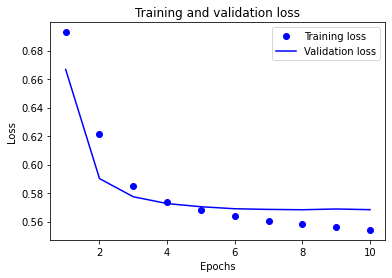

In [142]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

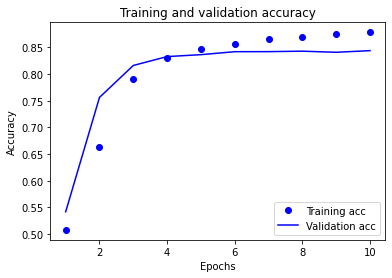

In [143]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

## Add vectorization layer to model 

In [81]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer=tf.keras.optimizers.Adam(1e-4), metrics=tf.metrics.BinaryAccuracy(threshold=0.5)
)

In [84]:
export_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 100)               0         
_________________________________________________________________
sequential (Sequential)      (None, 1)                 240305    
Total params: 240,305
Trainable params: 240,305
Non-trainable params: 0
_________________________________________________________________


In [83]:
# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(test_text_ds)
print(accuracy)

1246/1246 [==============================] - 7s 5ms/step - loss: 0.5889 - binary_accuracy: 0.8300
0.8320078253746033


## Try with positive and negative sentences

In [106]:
export_model.predict(['the book is amazing', 'the movie was ok', 'the book is terrible'])

array([[0.7883086 ],
       [0.02502945],
       [0.01544669]], dtype=float32)

In [94]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [99]:
history = model.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=epochs,
    callbacks=[cp_callback]
)

Epoch 1/10
2483/2483 [==============================] - 12s 5ms/step - loss: 0.7114 - binary_accuracy: 0.4953 - val_loss: 0.6911 - val_binary_accuracy: 0.4793

Epoch 00001: saving model to training_1\cp.ckpt
Epoch 2/10
2483/2483 [==============================] - 11s 5ms/step - loss: 0.6925 - binary_accuracy: 0.4952 - val_loss: 0.6866 - val_binary_accuracy: 0.4793

Epoch 00002: saving model to training_1\cp.ckpt
Epoch 3/10
2483/2483 [==============================] - 9s 4ms/step - loss: 0.6853 - binary_accuracy: 0.4961 - val_loss: 0.6634 - val_binary_accuracy: 0.5433

Epoch 00003: saving model to training_1\cp.ckpt
Epoch 4/10
2483/2483 [==============================] - 9s 4ms/step - loss: 0.6591 - binary_accuracy: 0.6123 - val_loss: 0.6303 - val_binary_accuracy: 0.7366

Epoch 00004: saving model to training_1\cp.ckpt
Epoch 5/10
2483/2483 [==============================] - 9s 4ms/step - loss: 0.6278 - binary_accuracy: 0.7522 - val_loss: 0.6069 - val_binary_accuracy: 0.7881

Epoch 00005